
In an earlier [post](https://www.jtrive.com/posts/boostrap-chainladder-python/bootstrap-chainladder-python.html), I provided a step-by-step guide on performing the bootstrap chain ladder using Pandas. This method involves repeatedly resampling residuals from the original chain ladder model to generate a series of simulated datasets, each replicating the original data's claims development patterns. (For more background, refer to the previous post.)

Here we again walkthrough the bootstrap chain ladder step-by-step, this time using Polars, a high-performance DataFrame library built in Rust specifically designed for efficient data processing with large datasets. Unlike Pandas which is single-threaded, Polars leverages multi-core processors resulting in dramatically faster execution for many tasks. Although not needed for our work in this setting, Polars can also handle datasets larger than available memory, spilling to disk when necessary. In Pandas, we can only process datasets having size less than or equal to available system memory. 

Although Polars offers clear advantages over Pandas in many scenarios, this particular case isn’t one of them. Polars eliminates the concept of an index, which is a core feature of Pandas. But indices are especially valuable in this context for calculating age-to-age factors, identifying values along the latest diagonal, and squaring triangles. Additionally, while some insurers may store tens or hundreds of millions of claim records in their data warehouses, losses are typically aggregated by origin and development period ahead of a reserving analysis, resulting in datasets greatly reduced in size vs. transactional claim data. As a consequence, reserving actuaries typically don’t work with datasets large enough to necessitate parallel processing or out-of-core computation. 

Translating the original Pandas bootstrap chain ladder code to Polars provided a good opportunity to showcase the library's core features. However, many operations felt much less intuitive compared to their Pandas counterparts. Even so, I see this post as a valuable reference for specific Polars operations that I’ll likely use again in the future.


The steps to perform the bootstrap chain ladder:

1. Transform loss data into cumulative triangle representation.

2. Calculate all-year volume weighted age-to-age factors. 

3. Calculate the cumulative fitted triangle by applying backwards recursion, beginning with the observed cumulative losses from the latest diagonal.

4. Calculate the unscaled Pearson residuals, $r_{p}$, degrees of freedom $DF$ and scale parameter $\phi$.

5. Calculate the adjusted Pearson residuals, defined as $r_{p}^{{adj}} = \sqrt{\frac{n}{DF}} \times r_{p}$.

6. For each bootstrap sample (1...1000):

    i. Generate a sample from the adjusted Pearson residuals $r_{p}^{{adj}}$ with replacement.

    ii. Using the sampled adjusted Pearson residuals and fitted incremental triangle $m$, construct the triangle of sampled incremental losses
    $I_{i} = m + \hat{r}_{p}^{adj} \sqrt{m}$, where $\hat{r}_{p}^{adj}$ represents a sample with replacement from the adjusted Pearson residuals and $m$ the fitted incremental triangle.

    iii. Create a cumulative triangle using the result from ii., and project future losses using the chain ladder method. 

    iv. Incorporate process variance by simulating each future projected incremental loss from a gamma distribution parameterized with mean equal to the projected loss value and variance the loss value times $\phi$.

    v. Cumulate the incremental losses, then compute the total needed reserve as the ultimate projected value minus the latest cumulative loss amount by origin period.


7. Compute desired quantiles of interest from predictive distribution of bootstrap samples.

<br>


In what follows each step is demonstrated, along with exhibits to visually assess the distribution of future losses.



In [1]:

%load_ext watermark

import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl

np.set_printoptions(suppress=True, precision=5)

pd.set_option("display.precision", 5)
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
warnings.simplefilter(action="ignore", category=FutureWarning)

pl.Config(tbl_rows=30)
pl.Config(float_precision=4)
pl.Config(tbl_cols=None)


%watermark --python --conda --hostname --machine --iversions


Python implementation: CPython
Python version       : 3.12.8
IPython version      : 8.31.0

conda environment: polars

Compiler    : MSC v.1942 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : Intel64 Family 6 Model 170 Stepping 4, GenuineIntel
CPU cores   : 22
Architecture: 64bit

Hostname: JTRIZPC11

polars    : 1.20.0
numpy     : 2.2.2
pandas    : 2.2.3
matplotlib: 3.10.0





Start by loading the data from GitHub:

In [2]:

# Load RAA dataset. 
dfraa = pl.read_csv("https://gist.githubusercontent.com/jtrive84/976c80786a6e97cce7483e306562f85b/raw/06a5c8b1f823fbe2b6da15f90a672517fa5b4571/RAA.csv")
dfraa = dfraa.sort(by=["ORIGIN", "DEV"])

print("Original incremental loss data:")

# Subtract 1980 from ORIGIN.
dfraa = dfraa.with_columns(pl.col("ORIGIN").sub(1980).alias("ORIGIN"))

dfraa.head(10)


Original incremental loss data:


ORIGIN,DEV,VALUE
i64,i64,i64
1,1,5012
1,2,3257
1,3,2638
1,4,898
1,5,1734
1,6,2642
1,7,1828
1,8,599
1,9,54



<br>

A number of functions are defined that will be used throughout the remainder of the article. Note that the implementations differ from the Pandas version: `to_cum` and `to_incr` accept an optional `as_tri` argument, which when set to `True` transforms the table of losses into a DataFrame formatted as a runoff triangle:


- `to_cum`: Accepts an incremental loss DataFrame and returns a cumulative loss DataFrame, optionally structured as a runoff triangle. 

- `to_incr`: Accepts a cumulative loss DataFrame and returns an incremental loss DataFrame, optionally structured as a runoff triangle. 

- `get_a2a_factors`: Accepts a cumulative triangle and returns the all-year volume weighted age-to-age factors.

- `get_latest`: Accepts a triangle and returns the value at the latest development period by origin. 

- `square_tri`: Accepts a cumulative triangle and set of age-to-age factors and projects future losses, populating the lower-right of the original cumulative triangle.

<br>

For `get_a2a_factors`, `get_latest` and `square_tri`, a few simplifying assumptions have been made:

1. The triangles under consideration have an equal number of development and origin periods. 
2. Development periods are sequential starting with 1.
3. No tail factor is included.


In [3]:


def to_tri(df: pl.DataFrame) -> pl.DataFrame:
    """
    Return DataFrame structured as runoff triangle.

    Args:
        df: pd.DataFrame
            Loss data with columns ORIGIN, DEV and VALUE.

    Returns:
        pl.DataFrame
    """
    return df.pivot(index="ORIGIN", on="DEV", values="VALUE")
    


def to_table(tri: pl.DataFrame) -> pl.DataFrame:
    """
    Accepts a DataFrame structured as a triangle and returns the tabular 
    representation having columns ORIGIN, DEV and VALUE.

    Args:
        df: pd.DataFrame
            Loss data structures as a runoff triangle.

    Returns:
        pl.DataFrame
    """
    df = tri.unpivot(tri.columns[1:], index=["ORIGIN"], variable_name="DEV", value_name="VALUE")
    df = df.with_columns(pl.col("DEV").cast(pl.Int32).alias("DEV"))
    df = df.sort(["ORIGIN", "DEV"])
    return df



def to_cum(df: pl.DataFrame, as_tri: bool=False) -> pl.DataFrame:
    """
    Accepts a DataFrame of incremental losses and returns a DataFrame
    of cumulative losses. Optionally return DataFrame as cumulative 
    triangle.

    Args:
        df : pl.DataFrame
            Incremental losses.

        as_tri: bool
            Should DataFrame be returned as a triangle.

    Returns:
        pl.DataFrame
    """
    dfc = df.with_columns(
        pl.col("VALUE").cum_sum().over("ORIGIN").alias("VALUE")
    )
    if as_tri:
        return to_tri(dfc)
    else:
        return dfc



def to_incr(df: pl.DataFrame, as_tri: bool=False) -> pl.DataFrame:
    """
    Accepts a DataFrame with cumulative losses and de-cumulates.

    Args:
        ctri : pl.DataFrame
            Cumulative losses.

        as_tri : bool
            Should DataFrame be returned as a triangle.

    Returns:
        pl.DataFrame  
    """
    # Get values at first development period.
    first_devp_values = df.filter(pl.col("DEV")==1).select("VALUE").to_numpy().flatten()

    # Compute difference of cumulative losses by each origin period.
    df = df.with_columns(VALUE=(pl.col("VALUE").diff()).over("ORIGIN"))

    if as_tri:
        # Convert to triangle.
        tri = to_tri(df)

        # Set first development period to first_devp_values. 
        tri = tri.with_columns(pl.Series("1", first_devp_values))
        
        return tri
    
    else:
        return df



def get_a2a_factors(tri: pl.DataFrame) -> list[tuple[str, float]]:
    """
    Calculate all-year volume weighted age-to-age factors. 

    Args:
        tri: pl.DataFrame
            Cumulative triangle.

    Returns:
        List of (age-to-age header, age-to-age factor).
    """
    max_origin = ctri0["ORIGIN"].max()
    all_devps = tri.columns[1:]
    dps0, dps1 = all_devps[:-1], all_devps[1:]
    a2a_headers = [f"{ii}-{jj}" for ii, jj in zip(dps0, dps1)]
    a2a = []
    for dp0, dp1 in zip(reversed(dps0), reversed(dps1)):
        v1 = tri.select(str(dp0)).to_numpy().flatten()[:(max_origin - int(dp1) + 1)]
        v2 = tri.select(str(dp1)).to_numpy().flatten()[:(max_origin - int(dp1) + 1)]
        a2a.append((np.nansum(v2) / np.nansum(v1)).item())
    return list(zip(a2a_headers, a2a[::-1]))
    
    

def get_latest(tri: pl.DataFrame) -> list[tuple[str, float]]:
    """
    Return the value at the latest development period by origin. 

    Args:
        tri : pl.DataFrame
            Cumulative or incremental triangle.

    Returns:
        list of (origin, latest) tuples.
    """
    if "ORIGIN" in tri.columns:
        tri = tri.drop("ORIGIN")
    nbr_devps = tri.width
    latest = [tri[ii, nbr_devps - ii - 1] for ii in range(nbr_devps)]
    return list(zip(tri.columns, latest))



def square_tri(tri: pl.DataFrame, a2a: list[tuple[str, float]]) -> pl.DataFrame:
    """
    Project future losses for `tri` using `a2a`.

    Args:
        tri : pl.DataFrame
            Cumulative triangle.
    
        a2a: list
            Age-to-age factors.

    Returns
    -------
    pl.DataFrame
        Original triangle with projected future losses. 
    """
    if "ORIGIN" in tri.columns:
        sqrd = tri.drop("ORIGIN")
    else:
        sqrd = tri
    _, a2a_values = zip(*a2a)
    nbr_devps = sqrd.width
    for r_idx in range(nbr_devps):
        for c_idx in range(nbr_devps - r_idx, nbr_devps):
            sqrd[r_idx, str(c_idx + 1)] =  sqrd[r_idx, str(c_idx)] * a2a_values[c_idx - 1]
    sqrd = sqrd.with_row_index("ORIGIN", offset=1)
    return sqrd





<br>

We start by creating an incremental runoff triangle, by passing `dfraa` DataFrame into `to_tri`:

In [4]:

tri0 = to_tri(dfraa)

print("Original incremental loss triangle:")

tri0

Original incremental loss triangle:


ORIGIN,1,2,3,4,5,6,7,8,9,10
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
1,5012,3257,2638,898,1734,2642,1828,599,54,172
2,106,4179,1111,5270,3116,1817,-103,673,535,null
3,3410,5582,4881,2268,2594,3479,649,603,null,null
4,5655,5900,4211,5500,2159,2658,984,null,null,null
5,1092,8473,6271,6333,3786,225,null,null,null,null
6,1513,4932,5257,1233,2917,null,null,null,null,null
7,557,3463,6926,1368,null,null,null,null,null,null
8,1351,5596,6165,null,null,null,null,null,null,null
9,3133,2262,null,null,null,null,null,null,null,null



<br>

Next we create a cumulative loss triangle using `to_cum` with `as_tri = True`:

In [5]:

ctri0 = to_cum(dfraa, as_tri=True)

print("Original cumulative loss triangle:")

ctri0


Original cumulative loss triangle:


ORIGIN,1,2,3,4,5,6,7,8,9,10
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
1,5012,8269,10907,11805,13539,16181,18009,18608,18662,18834
2,106,4285,5396,10666,13782,15599,15496,16169,16704,null
3,3410,8992,13873,16141,18735,22214,22863,23466,null,null
4,5655,11555,15766,21266,23425,26083,27067,null,null,null
5,1092,9565,15836,22169,25955,26180,null,null,null,null
6,1513,6445,11702,12935,15852,null,null,null,null,null
7,557,4020,10946,12314,null,null,null,null,null,null
8,1351,6947,13112,null,null,null,null,null,null,null
9,3133,5395,null,null,null,null,null,null,null,null



<br>

Calculate the all-year volume weighted age-to-age factors

$$
\begin{aligned}
  f_{k} &= \frac{\sum_{i=1}^{n-k}
C_{i,k+1}}{\sum_{i=1}^{n-k}C_{i,k}}
\end{aligned},
$$

for development period $i$.

In [6]:

a2a = get_a2a_factors(ctri0)

print("All-year volume weighted age-to-age factors:")

a2a


All-year volume weighted age-to-age factors:


[('1-2', 2.9993586513353794),
 ('2-3', 1.6235227537534538),
 ('3-4', 1.2708881150356526),
 ('4-5', 1.1716746330883747),
 ('5-6', 1.113384886206463),
 ('6-7', 1.0419346379110106),
 ('7-8', 1.033263553789384),
 ('8-9', 1.0169364810075625),
 ('9-10', 1.0092165898617511)]

<br>

Although not required here, age-to-ultimate factors can be obtained as follows:

In [7]:

h, v = zip(*a2a)

a2u = np.cumprod(v[::-1])[::-1]

print("Age-to-ultimate factors:")

list(zip(h, a2u.tolist()))


Age-to-ultimate factors:


[('1-2', 8.920233896752476),
 ('2-3', 2.9740470992960426),
 ('3-4', 1.8318481169544962),
 ('4-5', 1.441392121998959),
 ('5-6', 1.2301982831186211),
 ('6-7', 1.104917354599779),
 ('7-8', 1.0604478576650866),
 ('8-9', 1.0263091674684617),
 ('9-10', 1.0092165898617511)]


<br>

Calculate the cumulative fitted triangle by applying backwards recursion, beginning with the observed cumulative losses from the latest diagonal.




In [8]:

nbr_devps = ctri0.width - 1
a2a_headers, a2a_values = zip(*a2a)


# Create empty triangle with same shape as ctri0. 
ctri = pl.DataFrame(
    {f"{i}": [np.nan] * nbr_devps for i in range(1, 11)}
).with_row_index("ORIGIN", offset=1)


for r_idx in range(ctri["ORIGIN"].shape[0]):
    
    # Determine latest development period.
    latest_devp = nbr_devps - r_idx

    # Set latest diagonal of tri to same value as in tri0.
    ctri[r_idx, str(latest_devp)] = ctri0[r_idx, str(latest_devp)] 

    # Use backward recursion to un-develop triangle using a2a_values. 
    for devp in range(latest_devp - 1, 0, -1):

        ctri[r_idx, str(devp)] = (ctri[r_idx, str(devp + 1)] / a2a_values[devp - 1])


print("Fitted cumulative triangle:")

ctri


Fitted cumulative triangle:


ORIGIN,1,2,3,4,5,6,7,8,9,10
u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1,2111.3796,6332.7847,10281.4201,13066.5346,15309.7271,17045.6188,17760.4206,18351.1953,18662.0000,18834.0000
2,1889.8556,5668.3547,9202.7029,11695.6057,13703.4445,15257.2080,15897.0135,16425.8047,16704.0000,NaN
3,2699.8587,8097.8445,13147.0348,16708.4103,19576.8205,21796.5360,22710.5659,23466.0000,NaN,NaN
4,3217.7567,9651.2063,15668.9531,19913.4862,23332.1267,25977.6372,27067.0000,NaN,NaN,NaN
5,3242.8226,9726.3881,15791.0124,20068.6100,23513.8813,26180.0000,NaN,NaN,NaN,NaN
6,2186.1650,6557.0929,10645.5896,13529.3532,15852.0000,NaN,NaN,NaN,NaN,NaN
7,1989.7800,5968.0637,9689.2872,12314.0000,NaN,NaN,NaN,NaN,NaN,NaN
8,2692.6640,8076.2650,13112.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1798.7179,5395.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



<br>

Calculate the unscaled Pearson residuals, $r_{p}$, degrees of freedom $DF$ and scale parameter $\phi$.

The unscaled Pearson residuals are defined as

$$
r_{p} = \frac{I - m}{\sqrt{m}},
$$

where $I$ represents actual incremental losses and $m$ fitted incremental losses. 


Polars doesn't have an equivalent to Pandas `df.diff(axis=1)`, so the implementation of `to_incr` is a little more involved than what we saw last post. First, the actual triangle on incremental losses:



In [9]:

print("Actual incremental triangle tri:")

tri0


Actual incremental triangle tri:


ORIGIN,1,2,3,4,5,6,7,8,9,10
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
1,5012,3257,2638,898,1734,2642,1828,599,54,172
2,106,4179,1111,5270,3116,1817,-103,673,535,null
3,3410,5582,4881,2268,2594,3479,649,603,null,null
4,5655,5900,4211,5500,2159,2658,984,null,null,null
5,1092,8473,6271,6333,3786,225,null,null,null,null
6,1513,4932,5257,1233,2917,null,null,null,null,null
7,557,3463,6926,1368,null,null,null,null,null,null
8,1351,5596,6165,null,null,null,null,null,null,null
9,3133,2262,null,null,null,null,null,null,null,null



<br>

And the fitted incremental triangle:


In [10]:

# Fitted incremental triangle.
tri = to_incr(to_table(ctri), as_tri=True)

print("Fitted incremental triangle tri:")

tri


Fitted incremental triangle tri:


ORIGIN,1,2,3,4,5,6,7,8,9,10
u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1,2111.3796,4221.4051,3948.6354,2785.1145,2243.1925,1735.8917,714.8019,590.7747,310.8047,172.0000
2,1889.8556,3778.4991,3534.3481,2492.9028,2007.8388,1553.7635,639.8055,528.7912,278.1953,NaN
3,2699.8587,5397.9858,5049.1903,3561.3755,2868.4102,2219.7156,914.0298,755.4341,NaN,NaN
4,3217.7567,6433.4496,6017.7467,4244.5332,3418.6404,2645.5105,1089.3628,NaN,NaN,NaN
5,3242.8226,6483.5655,6064.6243,4277.5976,3445.2713,2666.1187,NaN,NaN,NaN,NaN
6,2186.1650,4370.9279,4088.4966,2883.7637,2322.6468,NaN,NaN,NaN,NaN,NaN
7,1989.7800,3978.2838,3721.2235,2624.7128,NaN,NaN,NaN,NaN,NaN,NaN
8,2692.6640,5383.6010,5035.7350,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1798.7179,3596.2821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



<br>

The unscaled Pearson residuals are then calculated element-wise:


In [11]:

numer = tri0.select(tri0.columns[1:]) - tri.select(tri.columns[1:]) 
denom = tri.select(pl.col(tri0.columns[1:]).abs().sqrt())
r_us = numer / denom

print("Unscaled Pearson residuals:")

r_us


Unscaled Pearson residuals:


1,2,3,4,5,6,7,8,9,10
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
63.1259,-14.8433,-20.8573,-35.7583,-10.7510,21.7480,41.6370,0.3384,-14.5666,0.0000
-41.0341,6.5154,-40.7625,55.6209,24.7308,6.6781,-29.3664,6.2712,15.3967,null
13.6670,2.5046,-2.3670,-21.6728,-5.1237,26.7285,-8.7663,-5.5461,null,null
42.9657,-6.6508,-23.2906,19.2704,-21.5437,0.2428,-3.1923,null,null,null
-37.7697,24.7072,2.6501,31.4266,5.8049,-47.2769,null,null,null,null
-14.3973,8.4866,18.2746,-30.7401,12.3326,null,null,null,null,null
-32.1201,-8.1696,52.5357,-24.5299,null,null,null,null,null,null
-25.8555,2.8948,15.9135,null,null,null,null,null,null,null
31.4605,-22.2495,null,null,null,null,null,null,null,null



<br>

$DF = n - p$, where $n$ is the number of populated cells in the original triangle and $p$ the number of parameters in the chain ladder model (10 for origin period and 9 for development period):

In [12]:

n = tri0.count().sum().to_numpy().flatten()[1:].sum().item()
p = tri0.height + tri0.width - 2
DF = n - p

print(f"Degrees of freedom: {DF}.")


Degrees of freedom: 36.



<br>

The scale parameter $\phi$ is the sum of the squared unscaled Pearson residuals over the degrees of freedom:

In [13]:

phi = r_us.with_columns(pl.all().pow(2)).sum().to_numpy().flatten().sum().item() / DF

print(f"Scale parameter: {phi:.3f}.")


Scale parameter: 983.635.



<br>

Calculate the adjusted Pearson residuals, $r_{p}^{{adj}}$, defined as:

$$
r_{p}^{{adj}} = \sqrt{\frac{n}{DF}} \times r_{p}
$$


In [14]:

r_adj = np.sqrt(n / DF).item() * r_us  

print("Adjusted Pearson residuals:")

r_adj


Adjusted Pearson residuals:


1,2,3,4,5,6,7,8,9,10
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
78.0257,-18.3468,-25.7803,-44.1984,-13.2886,26.8812,51.4647,0.4183,-18.0048,0.0000
-50.7196,8.0533,-50.3838,68.7493,30.5681,8.2544,-36.2979,7.7514,19.0308,null
16.8929,3.0957,-2.9256,-26.7883,-6.3330,33.0374,-10.8354,-6.8551,null,null
53.1071,-8.2206,-28.7879,23.8188,-26.6287,0.3001,-3.9458,null,null,null
-46.6845,30.5389,3.2756,38.8443,7.1751,-58.4358,null,null,null,null
-17.7955,10.4897,22.5880,-37.9958,15.2434,null,null,null,null,null
-39.7015,-10.0978,64.9359,-30.3197,null,null,null,null,null,null
-31.9582,3.5780,19.6696,null,null,null,null,null,null,null
38.8863,-27.5012,null,null,null,null,null,null,null,null




<br>

(From this point each subsequent step is repeated up to the desired number of bootstrap samples.)

Generate a sample from the adjusted Pearson residuals with replacement:


In [15]:

# Set random seed for reproducibility.
rng = np.random.default_rng(seed=516)

# Represent adjusted residuals as Numpy array with nans and 0s removed.
r = r_adj[:-1, :-1].to_numpy().flatten()
r = r[np.logical_and(~np.isnan(r), r != 0)] 

# Sample tri0.shape[0] * tri0.shape[1] values at each iteration, but only
# keep values in upper left portion of triangle. Use mask to determine 
# which values to retain.
mask = ~np.isnan(tri[:,1:])

# Sample with replacement from adjusted residuals. 
s_r = rng.choice(r, size=mask.shape, replace=True)

# # Replace 0s with nans.
s_r = mask * s_r
s_r[s_r==0] = np.nan
s_r = pl.from_numpy(s_r, schema=[str(i) for i in range(1, 11)])

print("Sample with replacement from adjusted Pearson residuals:")

s_r


Sample with replacement from adjusted Pearson residuals:


1,2,3,4,5,6,7,8,9,10
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
-50.3838,-13.2886,7.1751,30.5389,26.8812,-18.3468,-58.4358,33.0374,10.4897,7.1751
-10.0978,8.2544,-26.7883,0.4183,78.0257,-58.4358,38.8443,-30.3197,19.6696,NaN
-27.5012,38.8443,-58.4358,-6.3330,7.1751,-27.5012,0.4183,-50.7196,NaN,NaN
-44.1984,8.0533,-37.9958,-27.5012,38.8443,-25.7803,-30.3197,NaN,NaN,NaN
19.0308,-3.9458,-26.7883,-2.9256,38.8863,7.7514,NaN,NaN,NaN,NaN
30.5681,-27.5012,26.8812,8.2544,38.8443,NaN,NaN,NaN,NaN,NaN
-39.7015,-17.7955,-18.3468,-10.8354,NaN,NaN,NaN,NaN,NaN,NaN
22.5880,-18.0048,3.0957,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-25.7803,-26.7883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



<br>

Using the sampled adjusted Pearson residuals and fitted incremental triangle $m$, construct the triangle of sampled incremental losses ${I_{i}}$:

$$
I_{i} = m + \hat{r}_{p}^{adj} \sqrt{m},
$$

where $\hat{r}_{p}^{adj}$ represents a sample with replacement from the adjusted Pearson residuals and $m$ the fitted incremental triangle:

In [16]:

tri_ii = tri[:,1:] + s_r * tri.select(pl.col(tri.columns[1:]).sqrt())
tri_ii = tri_ii.with_row_index("ORIGIN", offset=1)

print("Triangle of sampled incremental loss tri_ii:")

tri_ii


Triangle of sampled incremental loss tri_ii:


ORIGIN,1,2,3,4,5,6,7,8,9,10
u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1,-203.7452,3358.0144,4399.5047,4396.7778,3516.3502,971.4887,-847.5257,1393.7759,495.7340,266.1004
2,1450.8774,4285.8909,1941.7709,2513.7873,5504.0870,-749.6490,1622.3472,-168.4248,606.2675,NaN
3,1270.8943,8251.9128,896.8769,3183.4392,3252.6902,924.0302,926.6758,-638.6012,NaN,NaN
4,710.5888,7079.3951,3070.2582,2452.8309,5689.8317,1319.5115,88.6453,NaN,NaN,NaN
5,4326.5491,6165.8502,3978.4635,4086.2513,5727.7564,3066.3579,NaN,NaN,NaN,NaN
6,3615.4212,2552.7444,5807.3180,3327.0288,4194.7016,NaN,NaN,NaN,NaN,NaN
7,218.8165,2855.8569,2602.0332,2069.5944,NaN,NaN,NaN,NaN,NaN,NaN
8,3864.7765,4062.5315,5255.4183,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,705.3407,1989.8118,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



<br>

Create a cumulative triangle, and project future losses using the chain ladder method:

In [17]:

# Create cumulative triangle from sampled incremental losses.
ctri_ii = to_cum(to_table(tri_ii), as_tri=True)

# Get age-to-age factors for sampled cumulative triangle.
a2a_ii = get_a2a_factors(ctri_ii)

# Square ctri_ii, populating the lower-right side using a2a_ii.
ctri_ii_sqrd = square_tri(ctri_ii, a2a_ii)

print("Completed sampled triangle ctri_ii_sqrd:")

ctri_ii_sqrd


Completed sampled triangle ctri_ii_sqrd:


ORIGIN,1,2,3,4,5,6,7,8,9,10
u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1,-203.7452,3154.2692,7553.7739,11950.5517,15466.9019,16438.3906,15590.8649,16984.6408,17480.3748,17746.4752
2,1450.8774,5736.7683,7678.5392,10192.3265,15696.4135,14946.7645,16569.1116,16400.6868,17006.9544,17265.8480
3,1270.8943,9522.8071,10419.6840,13603.1232,16855.8134,17779.8436,18706.5194,18067.9182,18664.3141,18948.4374
4,710.5888,7789.9839,10860.2421,13313.0730,19002.9047,20322.4162,20411.0615,20646.5050,21328.0164,21652.6887
5,4326.5491,10492.3993,14470.8628,18557.1141,24284.8704,27351.2284,28055.8538,28379.4807,29316.2465,29762.5220
6,3615.4212,6168.1656,11975.4836,15302.5124,19497.2140,20678.4336,21211.1538,21455.8265,22164.0523,22501.4514
7,218.8165,3074.6735,5676.7067,7746.3011,10351.3688,10978.4964,11261.3256,11391.2261,11767.2341,11946.3644
8,3864.7765,7927.3080,13182.7263,17413.9552,23270.2385,24680.0431,25315.8531,25607.8739,26453.1529,26855.8442
9,705.3407,2695.1525,4093.6863,5407.6272,7226.2030,7663.9954,7861.4361,7952.1185,8214.6065,8339.6559



<br> 

So far we've accounted for parameter variance, but not process variance. In order to obtain the full prediction error, we need to incorporate process variance into our estimates. This is accomplished by simulating incremental projected losses from a gamma distribution. For each cell in the lower right of the completed triangle, we randomly sample from a gamma distribution with mean equal to the projected incremental loss in that cell, and variance equal to the value in that cell times $\phi$. For example, consider the following squared incremental triangle:

```
      1  2  3  4  5  6  7  8  9  10
1991  84 27  6  6  3  0  2 -1 -0  2
1992 109 33  7  2  4  4  1 -1  1  2
1993  86 28  8  4  3  2 -0  1  0  2
1994 113 32  1  4  3  2 -1 -0  0  2
1995  86 26  6  3  2  2  0 -0  0  2
1996 107 39  7  4  4  2  1 -0  0  2
1997  72 26  2  3  2  2  0 -0  0  1
1998  77 21  3  3  2  2  0 -0  0  1
1999  74 28  4  3  2  2  0 -0  0  1
2000  54 17  3  2  2  1  0 -0  0  1
```

<br>

Values to the right of the main diagonal represent projected future losses. For the loss at origin = 2000 and development period = 2, the projected incremental loss is 17. We would therefore sample from a gamma distribution parameterized as follows:

```python
from numpy.random import gamma

# Computed above. 
phi = .798 

# Value at intersection of origin=2000 and development period = 2.
mu = 17

# Determine shape and scale from mean and variance.
shape = mu**2 / (phi * mu)
scale = (phi * mu) / mu

# Generate sample from gamma distribution.
rng.gamma(shape=shape, scale=scale, size=1)
# array([19.29149])
```

<br>

We take advantage of the fact that for the gamma distribution, the shape parameter $\alpha = E[X]^{2} / \mathrm{Var}[X]$ and scale $\theta = \mathrm{Var}[X] / E[X]$. In essence, we are simulating future incremental losses from a series a gamma distributions, each with parameterization based on the chain ladder-derived future incremental losses. To handle cases in which a projected incremental loss might be negative, we take the absolute value of the projected loss when determining $\alpha_{ij}$ and $\theta_{ij}$ for origin period $i$, development period $j$, where $2 \leq i \leq n$ and $j \geq n - i + 2$.



In [18]:
"""
Incorporation of process variance. 
"""

from numpy.random import gamma


# Get sampled squared incremental triangle.
tri_ii_sqrd = to_incr(to_table(ctri_ii_sqrd), as_tri=True).drop("ORIGIN")

for r_idx in range(nbr_devps):

    for c_idx in range(nbr_devps - r_idx, nbr_devps):
        # Get mean and variance using incremental loss value.
        m = np.abs(tri_ii_sqrd[r_idx, str(c_idx)])
        v = m * phi

        # Determine shape and scale parameters. 
        shape = m**2 / v
        scale = v / m

        # Update value at [r_idx, c_idx] with sample from gamma distribution.
        tri_ii_sqrd[r_idx, str(c_idx)] = rng.gamma(shape=shape, scale=scale, size=1).item()


print("Sampled incremental triangle w/ process variance:")

tri_ii_sqrd


Sampled incremental triangle w/ process variance:


1,2,3,4,5,6,7,8,9,10
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
-203.7452,3358.0144,4399.5047,4396.7778,3516.3502,971.4887,-847.5257,1393.7759,495.7340,266.1004
1450.8774,4285.8909,1941.7709,2513.7873,5504.0870,-749.6490,1622.3472,-168.4248,5.6818,258.8936
1270.8943,8251.9128,896.8769,3183.4392,3252.6902,924.0302,926.6758,261.2162,45.4568,284.1233
710.5888,7079.3951,3070.2582,2452.8309,5689.8317,1319.5115,0.0000,1187.7049,138.5052,324.6723
4326.5491,6165.8502,3978.4635,4086.2513,5727.7564,2287.3879,375.7417,20.5246,624.2870,446.2756
3615.4212,2552.7444,5807.3180,3327.0288,3960.9182,218.8131,10.1640,14.2730,306.6162,337.3991
218.8165,2855.8569,2602.0332,1195.7353,962.9821,160.2781,418.3009,0.0000,14.9545,179.1303
3864.7765,4062.5315,8917.8595,1226.2463,3936.2469,2824.7474,827.3206,4.3581,84.7208,402.6913
705.3407,1146.8776,1215.0414,619.7826,3797.3911,796.3057,8.3274,2.0791,0.2504,125.0494



<br>

From this point, we proceed exactly as if performing a standard chain ladder analysis: Cumulate incremental losses, then compute the total needed reserve as the ultimate projected value minus the latest cumulative loss amount by origin period. In the next cell we convert `latest_values` to a numpy array to simplify differencing with ultimates, but this can also be computed element-wise in a list comprehension:

In [19]:

tri_ii_sqrd = tri_ii_sqrd.with_row_index("ORIGIN", offset=1)
ctri_ii_sqrd = to_cum(to_table(tri_ii_sqrd), as_tri=True)
latest_origin, latest_values = zip(*get_latest(ctri_ii_sqrd))
latest_values = np.asarray(latest_values)
ultimates = ctri_ii_sqrd[:, -1].to_numpy().flatten()
ibnr = (ultimates - latest_values).tolist()

print("IBNR:")

ibnr


IBNR:


[0.0,
 258.89359253426665,
 329.5800615108092,
 1650.8823904054043,
 1466.8288652047886,
 887.2653700652991,
 1735.6459265833819,
 9306.331478679494,
 6564.227039438123,
 10435.842507396274]


The preceding steps are repeated for the desired number of bootstrap samples, resulting in the predictive distribution of total needed reserve by origin period and in aggregate.

<br>

### Bringing it All Together

The steps outlined above are combined in the next cell to run 1000 bootstrap iterations, generating the predictive distribution of reserves. We also present code to visualize the predictive distribution by origin period and in aggregate. 

In [20]:

import matplotlib.pyplot as plt
import numpy as np
from numpy.random import gamma
import polars as pl

np.set_printoptions(suppress=True, precision=5)
pl.Config(tbl_rows=30)
pl.Config(float_precision=4)
pl.Config(tbl_cols=None)
# Set random seed for reproducibility.
rng = np.random.default_rng(seed=516)

# Number of bootstrap samples.
nbr_samples = 1000

# Load tabular incremental losses. Convert to incremental triangle. 
dfraa = pl.read_csv("https://gist.githubusercontent.com/jtrive84/976c80786a6e97cce7483e306562f85b/raw/06a5c8b1f823fbe2b6da15f90a672517fa5b4571/RAA.csv")
dfraa = dfraa.sort(by=["ORIGIN", "DEV"])
dfraa = dfraa.with_columns(pl.col("ORIGIN").sub(1980).alias("ORIGIN"))
tri0 = to_tri(dfraa)
nbr_devps = tri0.width - 1
mask = ~np.isnan(tri0[:,1:])

# Create cumulative triangle from original losses.
ctri0 = to_cum(dfraa, as_tri=True)

# All-year volume-weighted age-to-age factors.
a2a = get_a2a_factors(ctri0)

# Cumulative fitted triangle via backwards recursion.
a2a_headers, a2a_values = zip(*a2a)

# Create empty triangle with same shape as ctri0. 
ctri = pl.DataFrame(
    {f"{i}": [np.nan] * nbr_devps for i in range(1, 11)}
).with_row_index("ORIGIN", offset=1)

for r_idx in range(ctri["ORIGIN"].shape[0]):

    # Determine latest development period.
    latest_devp = nbr_devps - r_idx

    # Set latest diagonal of tri to same value as in tri0.
    ctri[r_idx, str(latest_devp)] = ctri0[r_idx, str(latest_devp)] 

    # Use backward recursion to un-develop triangle using a2a_values. 
    for devp in range(latest_devp - 1, 0, -1):
        ctri[r_idx, str(devp)] = (ctri[r_idx, str(devp + 1)] / a2a_values[devp - 1])

# Incremental fitted triangle.
tri = to_incr(to_table(ctri), as_tri=True)

# Unscaled Pearson residuals.
numer = tri0.select(tri0.columns[1:]) - tri.select(tri.columns[1:]) 
denom = tri.select(pl.col(tri0.columns[1:]).abs().sqrt())
r_us = numer / denom

# Degrees of freedom.
n = tri0.count().sum().to_numpy().flatten()[1:].sum().item()
p = tri0.height + tri0.width - 2
DF = n - p

# Scale parameter.
phi = r_us.with_columns(pl.all().pow(2)).sum().to_numpy().flatten().sum().item() / DF

# Adjusted Pearson residuals.
r_adj = np.sqrt(n / DF).item() * r_us  

# Create sampling distribution from adjusted Pearson residuals. Remove
# nans and 0s. 
r = r_adj[:-1, :-1].to_numpy().flatten()
r = r[np.logical_and(~np.isnan(r), r != 0)] 

# Sample tri0.width * tri0.height values at each iteration, but only
# keep values in upper left portion of triangle. Use mask to determine 
# which values to retain.
sqrd_ctris = []

for ii in range(nbr_samples):

    # Sample with replacement from adjusted residuals. 
    s_r = rng.choice(r, size=mask.shape, replace=True)
    s_r = mask * s_r
    s_r[s_r==0] = np.nan
    s_r = pl.from_numpy(s_r, schema=[str(i) for i in range(1, 11)])

    # Sampled incremental triangle.
    tri_ii = tri[:,1:] + s_r * tri.select(pl.col(tri.columns[1:]).sqrt())
    tri_ii = tri_ii.with_row_index("ORIGIN", offset=1)

    # Sampled cumulative triangle.
    ctri_ii = to_cum(to_table(tri_ii), as_tri=True)

    # Age-to-age factors for sampled cumulative triangle.
    a2a_ii = get_a2a_factors(ctri_ii)

    # Sampled squared cumulative triangle.
    ctri_ii_sqrd = square_tri(ctri_ii, a2a_ii)

    # Sampled squared incremental triangle.
    tri_ii_sqrd = to_incr(to_table(ctri_ii_sqrd), as_tri=True)

    # Incorporate process variance.
    for r_idx in range(nbr_devps):
        for c_idx in range(nbr_devps - r_idx, nbr_devps):
            # Get mean and variance using incremental loss value.
            m = np.abs(tri_ii_sqrd[r_idx, str(c_idx)])
            v = m * phi

            # Determine shape and scale parameters. 
            shape = m**2 / v
            scale = v / m

            # Update value at [r_idx, c_idx] with sample from gamma distribution.
            tri_ii_sqrd[r_idx, str(c_idx)] = rng.gamma(shape=shape, scale=scale, size=1).item()

    ctri_ii_sqrd2 = to_cum(to_table(tri_ii_sqrd), as_tri=True)

    # Keep Sampled squared triangle.
    sqrd_ctris.append(ctri_ii_sqrd2)



<br>

Obtain the predictive distribution of reserves and ultimates from `sqrd_ctris`. Each triangle in `sqrd_ctris` is converted to a Pandas DataFrame to keep the visualization code consistent with the prior post:


In [21]:

ultimates, reserves = [], []

for ii, ctri in enumerate(sqrd_ctris):

    latest_origin, latest_values = zip(*get_latest(ctri))
    ctri = ctri.to_pandas().set_index("ORIGIN")
    latest = pd.Series(
        data=latest_values, index=[int(ii) for ii in latest_origin]
    )

    ult = (
        ctri.iloc[:, -1]
        .to_frame()
        .reset_index(drop=False)
        .rename({"ORIGIN": "origin", "10": "ult"}, axis=1)
    )

    ult["n"] = ii
    ultimates.append(ult)

    ibnr = (
        (ctri.iloc[:, -1] - latest).astype(float)
        .to_frame()
        .reset_index(drop=False)
        .rename({"ORIGIN": "origin", 0: "ibnr"}, axis=1)
    )

    ibnr["n"] = ii
    reserves.append(ibnr)

dfults = pd.concat(ultimates).reset_index(drop=True)
dfibnr = pd.concat(reserves).reset_index(drop=True)




<br>

Using `dfults` and `dfibnr`, we create a summary of mean ultimate, mean IBNR, standard error of IBNR as well as 75th and 95th percentiles of the predictive distribution of reserves:


In [22]:

from functools import reduce

# Latest cumulative loss amount by origin.
latest_origin, latest_values = zip(*get_latest(ctri0))
latest = (
    pd.Series(data=latest_values, index=[int(ii) for ii in latest_origin])
    .to_frame()
    .reset_index(drop=False)
    .rename({"index": "origin", 0: "latest"}, axis=1)
)

# Mean ultimate by origin.
ult_mean = (
    dfults.groupby("origin")["ult"].mean()
    .to_frame()
    .reset_index(drop=False)
    .rename({"ult": "ult_mean"}, axis=1)
)

ibnr_mean =  (
    dfibnr.groupby("origin")["ibnr"].mean()
    .to_frame()
    .reset_index(drop=False)
    .rename({"ibnr": "ibnr_mean"}, axis=1)
)

# Standard error of reserve distribution by origin. 
ibnr_se = (
    dfibnr.groupby("origin")["ibnr"].std(ddof=1)
    .to_frame()
    .reset_index(drop=False)
    .rename({"ibnr": "ibnr_se"}, axis=1)
)

# 75th percentile of reserve distribution by origin. 
ibnr_75 = (
    dfibnr.groupby("origin")["ibnr"].quantile(.75)
    .to_frame()
    .reset_index(drop=False)
    .rename({"ibnr": "ibnr_75th"}, axis=1)
)

# 95th percentile of reserve distribution by origin. 
ibnr_95 = (
    dfibnr.groupby("origin")["ibnr"].quantile(.95)
    .to_frame()
    .reset_index(drop=False)
    .rename({"ibnr": "ibnr_95th"}, axis=1)
)

# Combine into a single DataFrame.
bcl_summary = reduce(
    lambda df1, df2: df1.merge(df2, on="origin", how="left"),
    (latest, ult_mean, ibnr_mean, ibnr_se, ibnr_75, ibnr_95)
)

# Set ult_mean for earliest origin period to latest.
bcl_summary.at[0, "ult_mean"] = bcl_summary.at[0, "latest"]

print("Boostrap chain ladder summary by origin:")


bcl_summary.round(0)


Boostrap chain ladder summary by origin:


,origin,latest,ult_mean,ibnr_mean,ibnr_se,ibnr_75th,ibnr_95th
0,1,18834,18834.0,0.0,0.0,0.0,0.0
1,2,16704,17002.0,165.0,430.0,385.0,940.0
2,3,23466,24436.0,753.0,1056.0,1228.0,2719.0
3,4,27067,29034.0,1916.0,1714.0,2824.0,5079.0
4,5,26180,29014.0,2915.0,2085.0,4023.0,6865.0
5,6,15852,19656.0,3896.0,2452.0,5218.0,8692.0
6,7,12314,18031.0,5681.0,3066.0,7513.0,11501.0
7,8,13112,24818.0,11551.0,5142.0,14783.0,21143.0
8,9,5395,16291.0,10951.0,6283.0,14557.0,22634.0
9,10,2063,20003.0,17958.0,13786.0,25409.0,43653.0



<br> 

While results by origin can be useful, typically actuaries are more interested in the aggregate view. To get aggregate results, we first group by simulation number, then proceed as in the prior cell:


In [23]:

# Aggregate bootstrap chain ladder results.

agg_ults = dfults.groupby("n")["ult"].sum()
agg_ibnr = dfibnr.groupby("n")["ibnr"].sum()

dsumm = {
    "latest": [latest["latest"].sum().item()],
    "ult_mean": [agg_ults.mean().item()],
    "ibnr_mean": [agg_ibnr.mean().item()],
    "ibnr_se": [agg_ibnr.std(ddof=1).item()],
    "ibnr_75th": [agg_ibnr.quantile(.75).item()],
    "ibnr_95th": [agg_ibnr.quantile(.95).item()]
}

bcl_summary_total = pd.DataFrame().from_dict(dsumm, orient="columns")
bcl_summary_total.index = ["total"]

print("Boostrap chain ladder summary in total:")

bcl_summary_total.round(0)


Boostrap chain ladder summary in total:


,latest,ult_mean,ibnr_mean,ibnr_se,ibnr_75th,ibnr_95th
total,160987,217184.0,55787.0,18960.0,66239.0,88935.0


<br>

## Visualizing Bootstrap Chain Ladder Results


We can visualize actuals and predictions together by origin out to ultimate with 90% prediction intervals for each forecast period. Starting with `sqrd_tris`, we transform the data to make it easier for plotting:





In [24]:


dflist = []

for tri in sqrd_ctris:

    dftri = (
        tri.to_pandas().set_index("ORIGIN")
        .reset_index(drop=False)
        .rename_axis(None, axis=1)
        .rename({"ORIGIN": "origin"}, axis=1)
        .melt(id_vars="origin", var_name="dev", value_name="bcl_value")
    )

    dflist.append(dftri)



df = pd.concat(dflist)
df["dev"] = df["dev"].astype(int)
df = df.sort_values(["origin", "dev"]).reset_index(drop=True)

# Compute mean, 5th and 95th percentile of prediction interval for each forecast period.
df = (
    df
    .groupby(["origin", "dev"], as_index=False)["bcl_value"]
    .agg({
        "bcl_mean": lambda v: v.mean(), 
        "bcl_95th": lambda v: v.quantile(.95),
        "bcl_5th": lambda v: v.quantile(.05)
    })
)

# Attach actual values from original cumulative triangle.
dfctri0 = (
    ctri0.to_pandas().set_index("ORIGIN")
    .reset_index(drop=False)
    .rename_axis(None, axis=1)
    .rename({"ORIGIN": "origin"}, axis=1)
    .melt(id_vars="origin", var_name="dev", value_name="actual_value")
)
dfctri0["dev"] = dfctri0["dev"].astype(int)

df = df.merge(dfctri0, on=["origin", "dev"], how="left")

# If actual_value is nan, then dev is a prediction for that origin. Otherwise
# it is an actual value. 
df["actual_devp_ind"] = df["actual_value"].map(lambda v: 1 if not np.isnan(v) else 0)
df["value"] = df.apply(lambda r: r.bcl_mean if r.actual_devp_ind==0 else r.actual_value, axis=1)

df.tail(10)


,origin,dev,bcl_mean,bcl_95th,bcl_5th,actual_value,actual_devp_ind,value
90,10,1,2044.92690,5819.41104,2.74973,2063.0,1,2063.00000
91,10,2,6523.89949,16103.08545,101.75998,NaN,0,6523.89949
92,10,3,10661.43665,25982.44515,319.20599,NaN,0,10661.43665
93,10,4,13682.08149,32977.99907,611.55764,NaN,0,13682.08149
94,10,5,16092.90839,38453.69231,799.41542,NaN,0,16092.90839
95,10,6,17973.94826,42833.83253,934.59346,NaN,0,17973.94826
96,10,7,18718.07392,45366.39099,1007.06181,NaN,0,18718.07392
97,10,8,19360.64161,46870.52200,1052.26676,NaN,0,19360.64161
98,10,9,19813.97172,47265.73702,1067.22772,NaN,0,19813.97172
99,10,10,20003.07058,47960.10396,1225.34543,NaN,0,20003.07058


<br>

Actuals with forecasts by origin year with 90% prediction intervals:

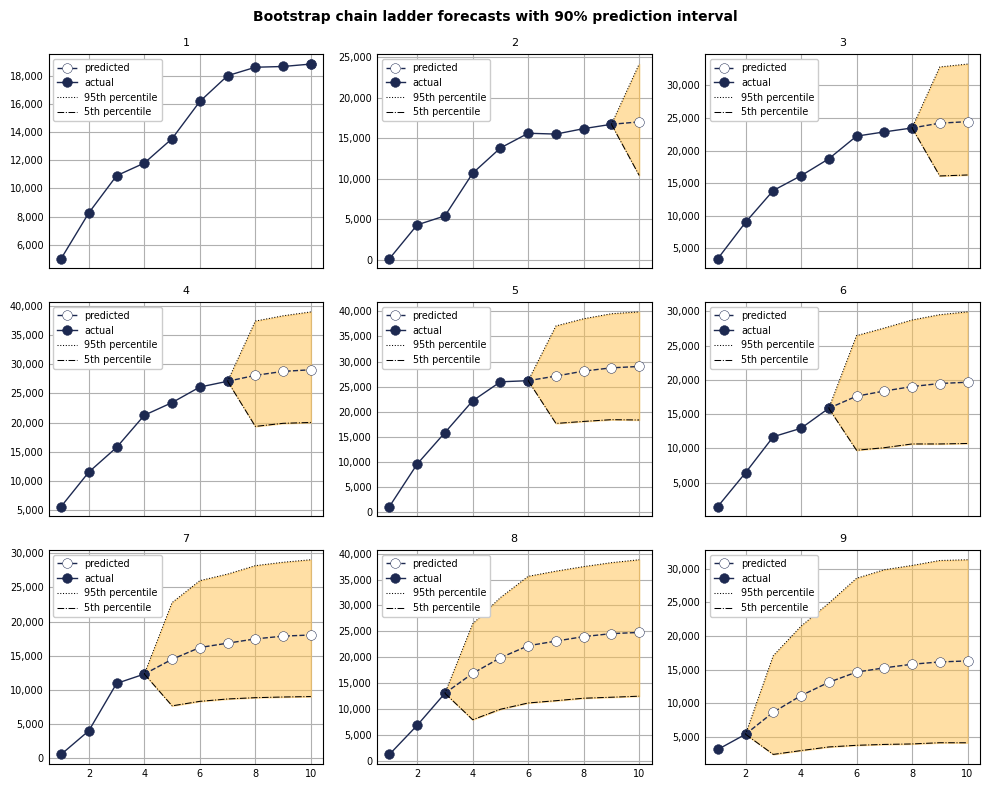

In [25]:

import matplotlib as mpl
from matplotlib.ticker import MaxNLocator


fill_color = "#FFC04C"


# Assume 9 origin periods (no distribution of fully-developed oldest origin period)
indices = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]
origin_periods = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

fig, ax = plt.subplots(3, 3, figsize=(10, 8), tight_layout=True, sharex=True) 

for (ii, jj), origin in zip(indices, origin_periods):

    dforigin = df[df.origin==origin]

    ax[ii, jj].set_title(f"{origin}", fontsize=8)

    # Get last actual development period for origin.
    last_actual_devp = dforigin[dforigin.actual_devp_ind==1].dev.max()

    # Actual values.
    act_dev = dforigin[dforigin.actual_devp_ind==1].dev.tolist()
    act_val = dforigin[dforigin.actual_devp_ind==1].value.tolist()

    # Predicted values.
    pred_dev = [last_actual_devp] + dforigin[dforigin.actual_devp_ind==0].dev.tolist()
    pred_val = [act_val[-1]] + dforigin[dforigin.actual_devp_ind==0].value.tolist()

    # 5th and 95th percentiles.
    pred_5th = [act_val[-1]] +  dforigin[dforigin.actual_devp_ind==0].bcl_5th.tolist()
    pred_95th = [act_val[-1]] + dforigin[dforigin.actual_devp_ind==0].bcl_95th.tolist()

    ax[ii, jj].plot(
        pred_dev, pred_val, "o", markersize=7, color="#1d2951", markerfacecolor="#FFFFFF", 
        markeredgecolor="#1d2951", markeredgewidth=.35, linestyle="--", linewidth=1., label="predicted"
    )

    ax[ii, jj].plot(
        act_dev, act_val, "o", markersize=7, color="#1d2951", markerfacecolor="#1d2951", 
         markeredgecolor="#1d2951", markeredgewidth=.35, linestyle="-", linewidth=1., label="actual"
    )

    ax[ii, jj].plot(
        pred_dev, pred_95th, color="#000000", linestyle=":",  # color="#FFFFB2",
        linewidth=.75, label="95th percentile"
    )

    ax[ii, jj].plot(
        pred_dev, pred_5th, color="#000000", linestyle="-.",  # color="#FFFFB2",
        linewidth=.75, label="5th percentile"
    )

    ax[ii, jj].fill_between(pred_dev, pred_5th, pred_95th, color=fill_color, alpha=.50)
    ax[ii, jj].xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:,.0f}"))
    ax[ii, jj].get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax[ii, jj].tick_params(axis="x", which="major", direction='in', labelsize=7)
    ax[ii, jj].tick_params(axis="y", which="major", direction='in', labelsize=7)
    ax[ii, jj].xaxis.set_ticks_position("none")
    ax[ii, jj].yaxis.set_ticks_position("none")
    ax[ii, jj].grid(True)   
    ax[ii, jj].set_axisbelow(True) 
    ax[ii, jj].legend(loc="upper left", fancybox=True, framealpha=1, fontsize="x-small")

plt.suptitle("Bootstrap chain ladder forecasts with 90% prediction interval", fontsize=10, weight="bold")

plt.show()



<br>

As expected, the prediction intervals grow wider for origin periods with fewer development periods of actual data to account for the greater uncertainty in ultimate projections.

Second, an exhibit with a separate histogram per facet can be used to visualize the distribution of IBNR generated by the bootstrap chain ladder:

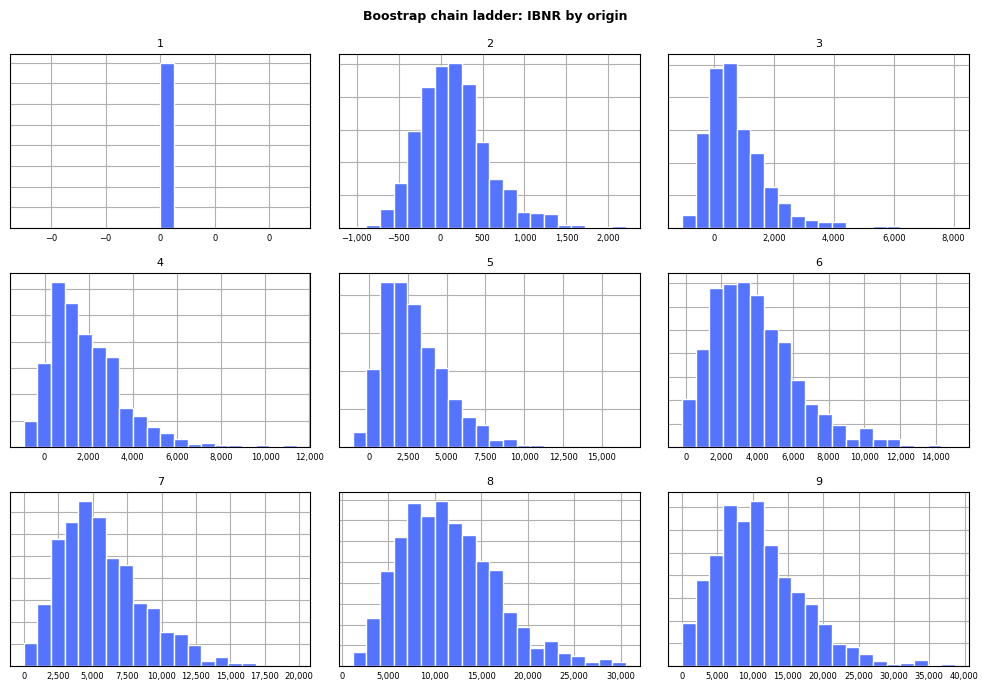

In [26]:

import matplotlib as mpl
import matplotlib.pyplot as plt


# Color for each histogram.
hist_color = "#5473ff"

# Assume 9 origin periods (no distribution of fully-developed oldest origin period)
indices = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]
origin_periods = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

fig, ax = plt.subplots(3, 3, figsize=(10, 7), tight_layout=True) 

for (ii, jj), origin in zip(indices, origin_periods):
    ax[ii, jj].set_title(str(origin), fontsize=8, weight="normal")
    ax[ii, jj].hist(
        dfibnr[dfibnr.origin==origin].ibnr, 20, density=True, alpha=1, 
        color=hist_color, edgecolor="#FFFFFF", linewidth=1.0
        )
    
    # ax[ii, jj].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:,.0f}"))
    ax[ii, jj].set_yticklabels([])
    ax[ii, jj].xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:,.0f}"))
    ax[ii, jj].tick_params(axis="x", which="major", direction='in', labelsize=6)
    ax[ii, jj].tick_params(axis="x", which="minor", direction='in', labelsize=6)
    ax[ii, jj].tick_params(axis="y", which="major", direction='in', labelsize=6)
    ax[ii, jj].tick_params(axis="y", which="minor", direction='in', labelsize=6)
    ax[ii, jj].xaxis.set_ticks_position("none")
    ax[ii, jj].yaxis.set_ticks_position("none")
    ax[ii, jj].grid(True)   
    ax[ii, jj].set_axisbelow(True) 

plt.suptitle("Boostrap chain ladder: IBNR by origin", fontsize=9, weight="bold")
plt.show()



<br>



Finally, we can create a similar exhibit for the aggregate distribution of IBNR, with vertical lines added at the 50th, 75th, 95th and 99th percentile of total needed reserve:

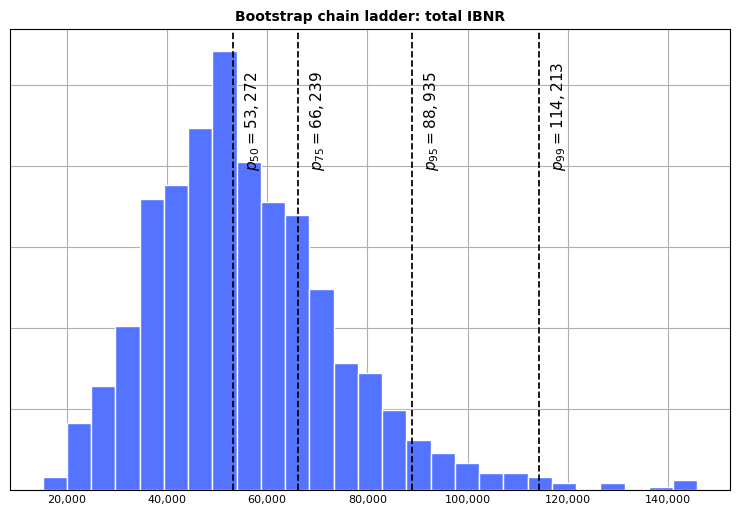

In [27]:

hist_color = "#5473ff"

dfibnr_total = dfibnr.groupby("n", as_index=False)["ibnr"].sum()
ibnr_total = dfibnr_total["ibnr"].values
ibnr_50 = np.quantile(ibnr_total, .50).item()
ibnr_75 = np.quantile(ibnr_total, .75).item()
ibnr_95 = np.quantile(ibnr_total, .95).item()
ibnr_99 = np.quantile(ibnr_total, .99).item()

fig, ax = plt.subplots(1, 1, figsize=(7.5, 5.25), tight_layout=True) 

ax.set_title("Bootstrap chain ladder: total IBNR", fontsize=10, weight="bold")

ax.hist(
    ibnr_total, 27, density=True, alpha=1, color=hist_color, 
    edgecolor="#FFFFFF", linewidth=1.0
    )

# 50th percentile.
ax.axvline(ibnr_50, color="#000000", linewidth=1.25, linestyle="--")
ax.annotate(
    r"$p_{{50}} = {:,.0f}$".format(ibnr_50), xycoords="data", xy=(ibnr_50, 2e-5),
    fontsize=11, rotation=90, weight="normal", color="#000000", xytext=(10, 0), 
    textcoords="offset pixels"
)

# 75th percentile.
ax.axvline(ibnr_75, color="#000000", linewidth=1.25, linestyle="--")
ax.annotate(
    r"$p_{{75}} = {:,.0f}$".format(ibnr_75), xycoords="data", xy=(ibnr_75, 2e-5),
    fontsize=11, rotation=90, weight="normal", color="#000000", xytext=(10, 0), 
    textcoords="offset pixels"
)

# 95th percentile.
ax.axvline(ibnr_95, color="#000000", linewidth=1.25, linestyle="--")
ax.annotate(
    r"$p_{{95}} = {:,.0f}$".format(ibnr_95), xycoords="data", xy=(ibnr_95, 2e-5),
    fontsize=11, rotation=90, weight="normal", color="#000000", xytext=(10, 0), 
    textcoords="offset pixels"
)

# 99th percentile.
ax.axvline(ibnr_99, color="#000000", linewidth=1.25, linestyle="--")
ax.annotate(
    r"$p_{{99}} = {:,.0f}$".format(ibnr_99), xycoords="data", xy=(ibnr_99, 2e-5),
    fontsize=11, rotation=90, weight="normal", color="#000000", xytext=(10, 0), 
    textcoords="offset pixels"
)

# ax[ii, jj].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:,.0f}"))
ax.set_yticklabels([])
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:,.0f}"))
ax.tick_params(axis="x", which="major", direction='in', labelsize=8)
# ax.tick_params(axis="x", which="minor", direction='in', labelsize=8)
ax.tick_params(axis="y", which="major", direction='in', labelsize=8)
# ax.tick_params(axis="y", which="minor", direction='in', labelsize=8)
ax.xaxis.set_ticks_position("none")
ax.yaxis.set_ticks_position("none")
ax.grid(True)   
ax.set_axisbelow(True) 
plt.show()
